# Classification of architectural styles using CNN and Transfer Learning

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers, regularizers
from keras.models import Sequential
from datetime import datetime 
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler

# load the TensorBoard notebook extension
%load_ext tensorboard

# dataset
path = 'archive-2/architectural-styles-dataset'

### Random guessing

We calculate the probability of guessing a correct style randomly

In [2]:
# number of styles:
items = os.listdir(path)
num_styles = 0
for item in items:
    if os.path.isdir(os.path.join(path, item)):
        num_styles += 1

items = os.listdir(path)

folder_image_counts = []
# go through items in the directory
for item in items:
    if os.path.isdir(os.path.join(path, item)):
        image_files = [f for f in os.listdir(os.path.join(path, item)) if f.endswith(".jpg") or f.endswith(".jpeg") or f.endswith(".png")]

        folder_image_counts.append((item, len(image_files)))
print(folder_image_counts)

image_counts = [count for _, count in folder_image_counts]

# total number of images in the dataset
total_images = sum(image_counts)
# probability of random guessing for each style
p_style = 1/num_styles
# weighted average probability of random guessing
p_random = 0
for count in image_counts:
    p_random += p_style * (count/total_images)
print("The probability of random guessing for this dataset is:", p_random)


[('Palladian architecture', 312), ('Novelty architecture', 327), ('International style', 367), ('Chicago school architecture', 237), ('Beaux-Arts architecture', 355), ('Ancient Egyptian architecture', 361), ('Gothic architecture', 330), ('Tudor Revival architecture', 422), ('Romanesque architecture', 267), ('Colonial architecture', 408), ('American craftsman style', 322), ('Greek Revival architecture', 449), ('Queen Anne architecture', 618), ('Baroque architecture', 376), ('Edwardian architecture', 266), ('Art Nouveau architecture', 491), ('Deconstructivism', 278), ('Bauhaus architecture', 295), ('Georgian architecture', 366), ('Byzantine architecture', 285), ('Postmodern architecture', 264), ('Achaemenid architecture', 373), ('Art Deco architecture', 427), ('American Foursquare architecture', 337), ('Russian Revival architecture', 314)]
The probability of random guessing for this dataset is: 0.04


# CNN

the code we used as a base: https://www.tensorflow.org/tutorials/images/classification

### Define parameters


In [117]:
# image size
img_height = 180 
img_width = 180 
IMG_SIZE = (img_height, img_width)

# hyperparameters
batch_size = 32
epochs = 35
lr = 0.001
# adam optimizer with learning rate scheduler
adam_opt = keras.optimizers.legacy.Adam(learning_rate=lr, decay=lr/epochs)
optimizer = adam_opt

### LOG

In [4]:
# for log
log_dir = "logs_cnn/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Use a summary writer to save the hyperparameters
with tf.summary.create_file_writer(log_dir).as_default():
  tf.summary.scalar('batch_size', data=batch_size, step=0)
  tf.summary.scalar('num_epochs', data=epochs, step=0)

2023-05-09 17:16:19.644263: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Create Training and Validation datasets

In [118]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="training",
    seed=123,          # 123 is aribtary, could be any integer. 
    image_size=IMG_SIZE,
    batch_size=batch_size,
    shuffle = True
)

Found 10113 files belonging to 25 classes.
Using 8091 files for training.


In [119]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    path, 
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE, 
    batch_size=batch_size,
    shuffle=True
)

Found 10113 files belonging to 25 classes.
Using 2022 files for validation.


In [120]:
# get names and number of all architectural styles
class_names = train_ds.class_names
num_classes = len(class_names)

### Visualize the data

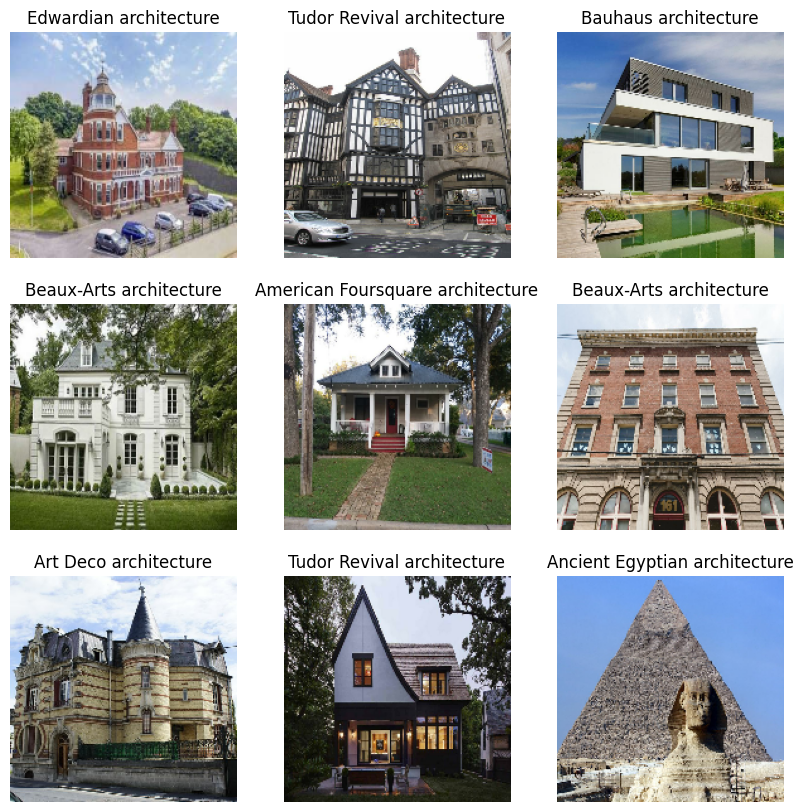

In [121]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


### Configure the dataset for performance 


In [122]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# These lines speeds up the training process. Caching ensures that we don't have to reload the data every time we use it.
# Prefetching ensures that we always have the next batch of data ready to go. 

### Standardize the data 

In [123]:
normalization_layer = layers.Rescaling(1./255)

### Data augmentation 

In [124]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomCrop(height=150, width=150),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomBrightness(0.1)])


2023-05-09 20:02:33.913621: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 131 of 1000
2023-05-09 20:02:42.826732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


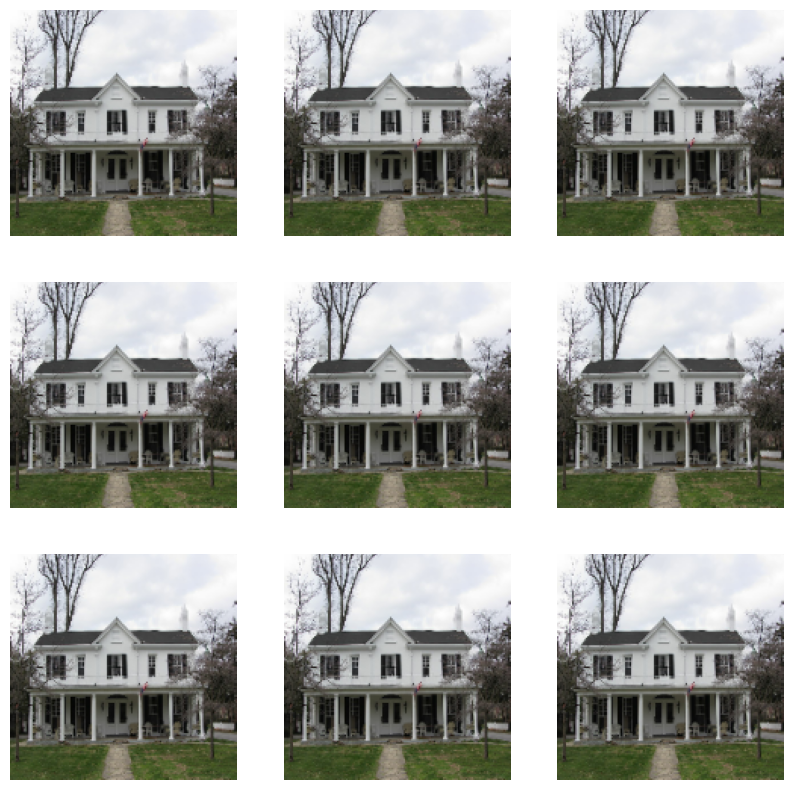

In [125]:
# visualize a random image with data augmentaion 
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create model

In [126]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dense(num_classes, name="outputs", activation='softmax')
])


In [127]:
model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #  need to check if another one is better. 
              metrics = ['accuracy'],
              )

In [128]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 batch_normalization_4 (Batc  (None, 150, 150, 16)     64        
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 150, 150, 16)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                  

### Train model

In [129]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[tensorboard_callback] # to keep track of log 
)

Epoch 1/35


/Users/annahansen/opt/anaconda3/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


253/253 [==============================] - 128s 490ms/step - loss: 2.8715 - accuracy: 0.1639 - val_loss: 4.2950 - val_accuracy: 0.0495
Epoch 2/35
253/253 [==============================] - 124s 492ms/step - loss: 2.4979 - accuracy: 0.2479 - val_loss: 3.6445 - val_accuracy: 0.1197
Epoch 3/35
253/253 [==============================] - 127s 503ms/step - loss: 2.3371 - accuracy: 0.3024 - val_loss: 3.0187 - val_accuracy: 0.1825
Epoch 4/35
253/253 [==============================] - 136s 537ms/step - loss: 2.2273 - accuracy: 0.3281 - val_loss: 2.3507 - val_accuracy: 0.3017
Epoch 5/35
253/253 [==============================] - 131s 517ms/step - loss: 2.1500 - accuracy: 0.3496 - val_loss: 2.4092 - val_accuracy: 0.2834
Epoch 6/35
253/253 [==============================] - 129s 510ms/step - loss: 2.0844 - accuracy: 0.3660 - val_loss: 2.5567 - val_accuracy: 0.2849
Epoch 7/35
253/253 [==============================] - 127s 501ms/step - loss: 2.0179 - accuracy: 0.3872 - val_loss: 2.2123 - val_accura

### Visualize training results

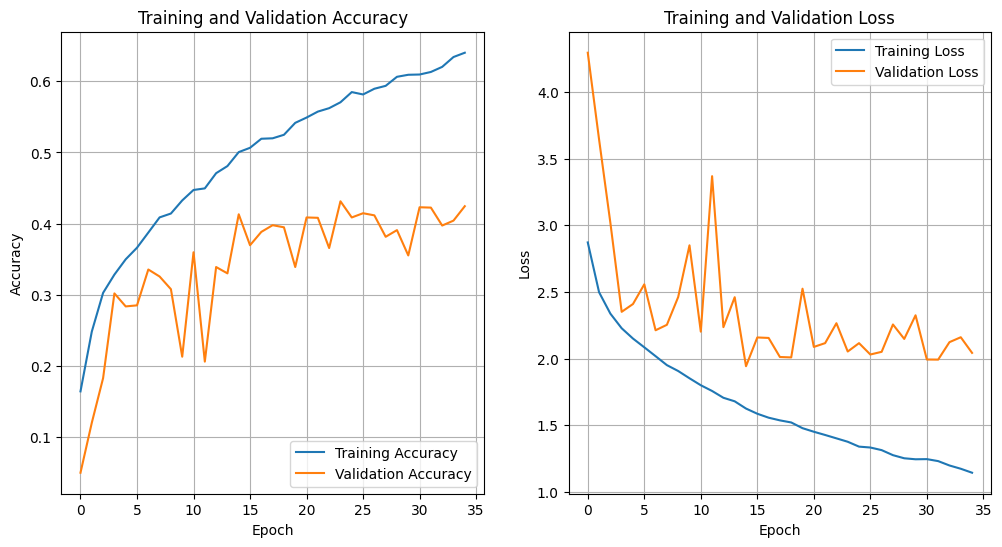

In [130]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot accuracy
axs[0].plot(epochs_range, acc, label='Training Accuracy')
axs[0].plot(epochs_range, val_acc, label='Validation Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend(loc='lower right')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].grid(True)

# Plot loss

axs[1].plot(epochs_range, loss, label='Training Loss')
axs[1].plot(epochs_range, val_loss, label='Validation Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend(loc='upper right')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].grid(True)

plt.show()

We got around 40perc accuracy.

In [ ]:
# %tensorboard --logdir logs_cnn    

## Transfer learning

In [87]:
BATCH_SIZE = 32     
IMG_SIZE = 160
epochs = 10

In [88]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="training",
    seed=123,   
    shuffle=True, 
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE)
    
)

Found 10113 files belonging to 25 classes.
Using 8091 files for training.


In [89]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    path, 
    validation_split=0.2,
    subset="validation",
    seed=123,   
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE)
    
)

Found 10113 files belonging to 25 classes.
Using 2022 files for validation.


In [90]:
# Convert integer labels to binary matrix
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, num_classes)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, num_classes)))

In [91]:
# create testset 
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 52
Number of test batches: 12


In [92]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE) 
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# These lines speeds up the training process. Caching ensures that we don't have to reload the data every time we use it.
# Prefetching ensures that we always have the next batch of data ready to go. 

In [93]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(160, 160, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomBrightness(0.1)])


In [94]:
# Rescale pixel values 
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# preprocess_input is used to preprocess input images in the same way that the MobileNetV2 was trained 

### Create base model

In [95]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(
                                        input_shape=IMG_SHAPE,
                                        include_top=False,
                                        weights='imagenet',
                                        )

# We load a network that doesn't include the classification layers on the top (include_top=False)

In [96]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

### Feature extraction

In [97]:
# Freeze the convolutional base 
base_model.trainable = False

In [98]:
# Add classification head

global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # convert the features to a single 1280-element vector per image.
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(25, activation='softmax') 
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1280)
(32, 25)


In [99]:
# Build the model 
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [106]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1)

In [101]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

### Train the model

In [102]:
initial_epochs = 20
loss0, accuracy0 = model.evaluate(val_ds)

52/52 [==============================] - 18s 294ms/step - loss: 3.7882 - accuracy: 0.0263


In [103]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/20
253/253 [==============================] - 115s 433ms/step - loss: 3.2821 - accuracy: 0.1001 - val_loss: 2.8326 - val_accuracy: 0.1624
Epoch 2/20
253/253 [==============================] - 117s 460ms/step - loss: 2.6190 - accuracy: 0.2290 - val_loss: 2.4335 - val_accuracy: 0.2582
Epoch 3/20
253/253 [==============================] - 118s 464ms/step - loss: 2.2885 - accuracy: 0.3102 - val_loss: 2.1959 - val_accuracy: 0.3364
Epoch 4/20
253/253 [==============================] - 118s 464ms/step - loss: 2.1095 - accuracy: 0.3606 - val_loss: 2.0680 - val_accuracy: 0.3785
Epoch 5/20
253/253 [==============================] - 119s 469ms/step - loss: 2.0016 - accuracy: 0.3887 - val_loss: 1.9659 - val_accuracy: 0.3913
Epoch 6/20
253/253 [==============================] - 125s 489ms/step - loss: 1.8975 - accuracy: 0.4164 - val_loss: 1.8811 - val_accuracy: 0.4237
Epoch 7/20
253/253 [==============================] - 130s 509ms/step - loss: 1.8279 - accuracy: 0.4374 - val_loss: 1.8307 -

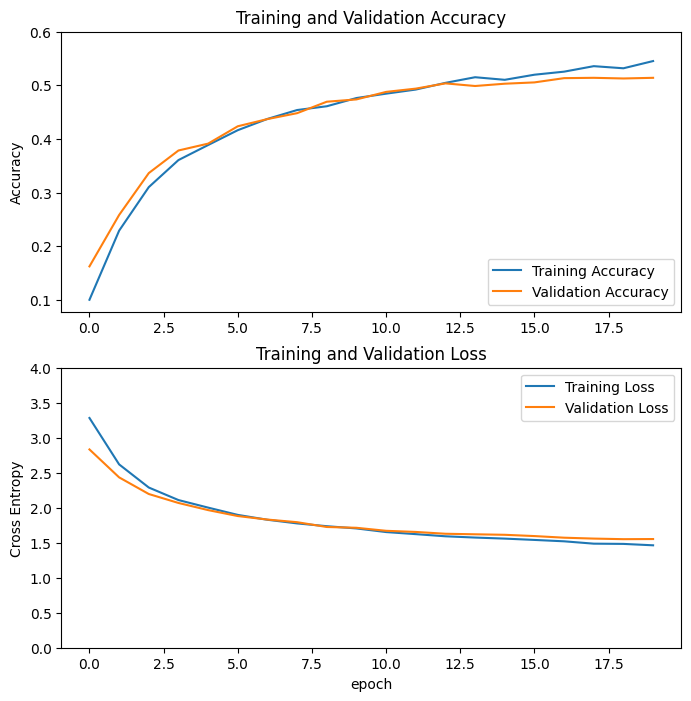

In [104]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),0.6])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine tuning

In [105]:
# Un-freeze top layers 
base_model.trainable = True

In [107]:
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer
fine_tune_at = 100

# Freeze all layers before the fine_tune_at' layer 
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


In [108]:
# compile model 

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [109]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [110]:
len(model.trainable_variables)

56

In [111]:
# Continue training the model

fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 20/30
253/253 [==============================] - 148s 558ms/step - loss: 1.4482 - accuracy: 0.5420 - val_loss: 1.4675 - val_accuracy: 0.5415
Epoch 21/30
253/253 [==============================] - 150s 590ms/step - loss: 1.3590 - accuracy: 0.5663 - val_loss: 1.4234 - val_accuracy: 0.5464
Epoch 22/30
253/253 [==============================] - 155s 609ms/step - loss: 1.3018 - accuracy: 0.5878 - val_loss: 1.3688 - val_accuracy: 0.5702
Epoch 23/30
253/253 [==============================] - 167s 658ms/step - loss: 1.2518 - accuracy: 0.6007 - val_loss: 1.3696 - val_accuracy: 0.5659
Epoch 24/30
253/253 [==============================] - 175s 686ms/step - loss: 1.2113 - accuracy: 0.6193 - val_loss: 1.3170 - val_accuracy: 0.5739
Epoch 25/30
253/253 [==============================] - 159s 623ms/step - loss: 1.1643 - accuracy: 0.6305 - val_loss: 1.2976 - val_accuracy: 0.5885
Epoch 26/30
253/253 [==============================] - 158s 623ms/step - loss: 1.1298 - accuracy: 0.6391 - val_loss: 1

In [112]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

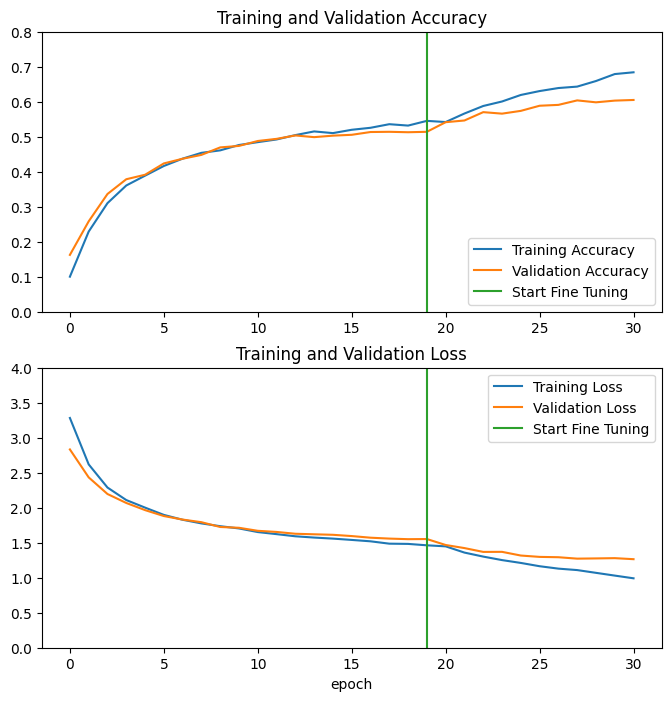

In [113]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 0.8])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 4.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


### Evaluation 

In [114]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

12/12 [==============================] - 5s 322ms/step - loss: 1.1885 - accuracy: 0.6250
Test accuracy : 0.625


Predictions:
 [ 2  4 10 22 21 19  7 23 10  0 21  8 24  0 21  3  5  0  2 14 16  0 18  0
  7  6  5 22 15 24 24  2]
Labels:
 [ 2  4 10 22 21 19 17 23  4  3 21 11 24  0 21  3 10  0  1 14 14  0 18  3
 17  6 13 22 15 24  2 13]
Predictions:
 ['American craftsman style', 'Art Deco architecture', 'Chicago school architecture', 'Romanesque architecture', 'Queen Anne architecture', 'Palladian architecture', 'Bauhaus architecture', 'Russian Revival architecture', 'Chicago school architecture', 'Achaemenid architecture', 'Queen Anne architecture', 'Beaux-Arts architecture', 'Tudor Revival architecture', 'Achaemenid architecture', 'Queen Anne architecture', 'Ancient Egyptian architecture', 'Art Nouveau architecture', 'Achaemenid architecture', 'American craftsman style', 'Georgian architecture', 'Greek Revival architecture', 'Achaemenid architecture', 'Novelty architecture', 'Achaemenid architecture', 'Bauhaus architecture', 'Baroque architecture', 'Art Nouveau architecture', 'Romanesque architectur

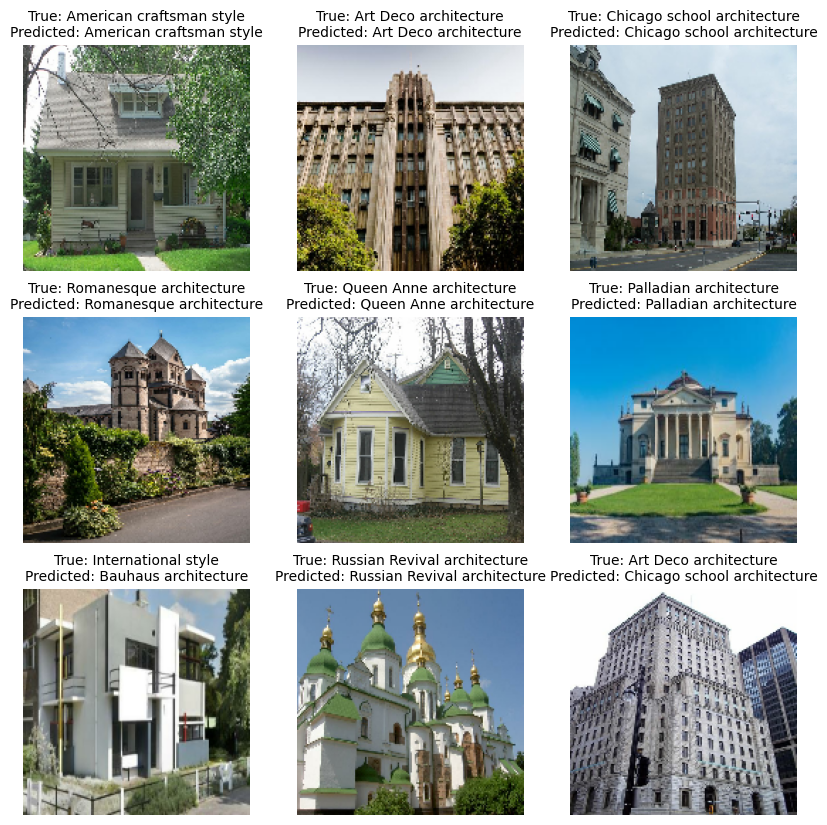

In [115]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()

# Get predictions for the batch of images
predictions = model.predict_on_batch(image_batch)

# Convert the predictions to class labels using argmax
predicted_labels = tf.argmax(predictions, axis=1)

# Convert one-hot encoded labels to class labels using argmax
true_labels = tf.argmax(label_batch, axis=1)

print('Predictions:\n', predicted_labels.numpy())
print('Labels:\n', true_labels.numpy())

# Convert integer labels to string labels using the class_names list
predicted_labels = [class_names[label] for label in predicted_labels.numpy()]
true_labels = [class_names[label] for label in true_labels.numpy()]

print('Predictions:\n', predicted_labels)
print('Labels:\n', true_labels)


plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  #plt.title(class_names[predicted_labels[i]])
  plt.title(f"True: {true_labels[i]}\nPredicted: {predicted_labels[i]}", fontsize=10)
  plt.axis("off")


### TOP į

In [116]:
# Get the top K predictions for the batch of images
top_k = 5
values, indices = tf.math.top_k(predictions, k=top_k)

# Convert the predicted and true labels to string labels using the class_names list
predicted_labels = [class_names[index] for index in tf.argmax(predictions, axis=1)]
true_labels = [class_names[index] for index in tf.argmax(label_batch, axis=1)]

# Print the top K predicted labels for each image
for i in range(len(image_batch)):
    print(f"\nImage {i} - True label: {true_labels[i]}")
    print("Predicted labels:")
    for j in range(top_k):
        pred_class = class_names[indices[i][j]]
        pred_prob = values[i][j].numpy()
        print(f"  {pred_class}: {pred_prob:.2f}")


Image 0 - True label: American craftsman style
Predicted labels:
  American craftsman style: 0.50
  Queen Anne architecture: 0.22
  American Foursquare architecture: 0.11
  Greek Revival architecture: 0.04
  Chicago school architecture: 0.02

Image 1 - True label: Art Deco architecture
Predicted labels:
  Art Deco architecture: 0.25
  Gothic architecture: 0.22
  Colonial architecture: 0.16
  Baroque architecture: 0.12
  Romanesque architecture: 0.07

Image 2 - True label: Chicago school architecture
Predicted labels:
  Chicago school architecture: 0.72
  Beaux-Arts architecture: 0.19
  Art Deco architecture: 0.07
  Postmodern architecture: 0.01
  Baroque architecture: 0.01

Image 3 - True label: Romanesque architecture
Predicted labels:
  Romanesque architecture: 0.68
  Byzantine architecture: 0.08
  Palladian architecture: 0.07
  Colonial architecture: 0.04
  Queen Anne architecture: 0.03

Image 4 - True label: Queen Anne architecture
Predicted labels:
  Queen Anne architecture: 0.54